In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as sp

In [3]:
df=pd.read_csv('test_stat_playlist.txt',index_col='id')
df.head()

,danceability,energy,key,loudness,mode,valence,tempo,duration_ms,time_signature
id,,,,,,,,,
1V9kNQy5UOsgRbgrNu595p,0.675,0.7800,10,-11.708,0,0.122,119.993,293200,4
3sn5gqosgrs0y1ljACKUCt,0.416,0.0775,6,-23.078,0,0.110,137.141,383851,4
1mcYsmqdy5B9zte056Cxgq,0.432,0.9170,1,-5.852,1,0.393,97.977,276280,4
2O2Pt2sbaUUA9o8CoRVOeW,0.589,0.7110,10,-5.011,0,0.384,118.733,236472,4
04Blc3wPUReZEVymBvn30i,0.415,0.7080,1,-10.456,1,0.344,109.197,195139,5


In [4]:
def minute_seconds(x) : 
    rounded = round(x/1000)
    minutes = rounded//60
    seconds = rounded%60
    return 

df['duration_seconds']=round(df['duration_ms']/1000)

<AxesSubplot: xlabel='key', ylabel='count'>

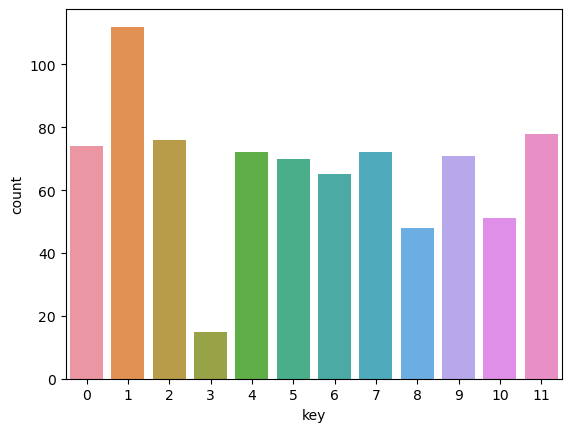

In [5]:
sns.countplot(data=df,x='key')

<AxesSubplot: xlabel='time_signature', ylabel='count'>

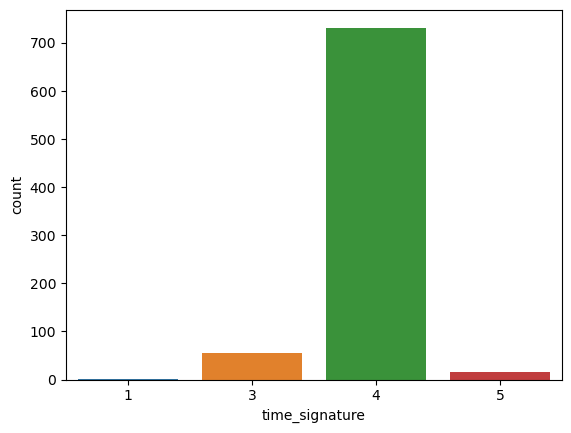

In [6]:
sns.countplot(data=df,x='time_signature')

<AxesSubplot: xlabel='duration_seconds'>

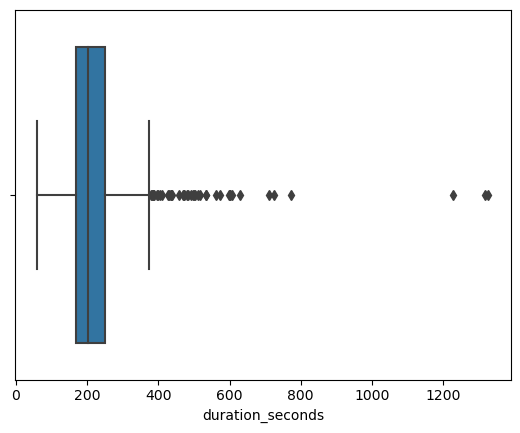

In [7]:
sns.boxplot(data=df,x='duration_seconds')

<AxesSubplot: >

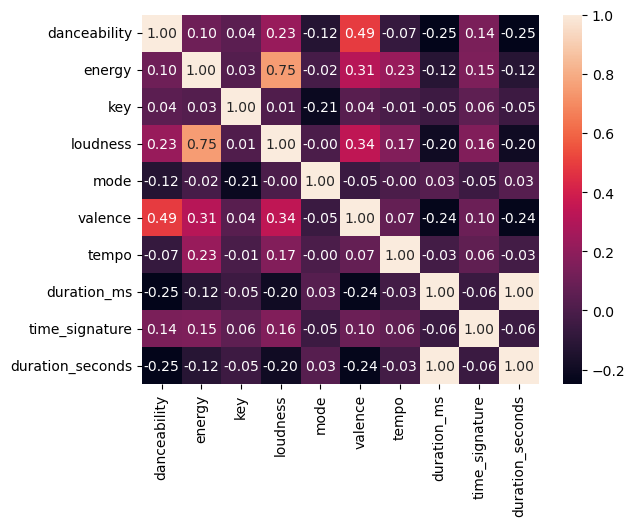

In [8]:
sns.heatmap(data=df.corr(),annot=True,fmt='.2f')

In [9]:
df_temp = df[df['time_signature']==5]
df_temp.head()

,danceability,energy,key,loudness,mode,valence,tempo,duration_ms,time_signature,duration_seconds
id,,,,,,,,,,
04Blc3wPUReZEVymBvn30i,0.415,0.708,1,-10.456,1,0.344,109.197,195139,5,195.0
4d7BPCLKQxZCr4ZzKhZzpB,0.226,0.785,6,-8.011,1,0.302,173.315,562329,5,562.0
2y8H9S10QJxh50QPg7ZR7r,0.374,0.176,7,-9.342,0,0.121,78.161,229625,5,230.0
4Om70ABodx5bhfnXW6150J,0.445,0.925,8,-3.229,0,0.515,86.466,126431,5,126.0
3X2xKuavDwk7I5B5XIxPWS,0.609,0.618,11,-6.573,0,0.364,123.682,189670,5,190.0


In [10]:
px.box(df,x='duration_seconds') 

NameError: name 'px' is not defined

La durée des morceaux ne semble pas suivre une loi normale

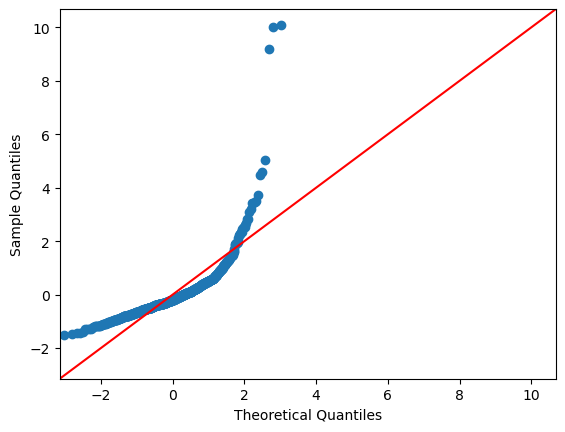

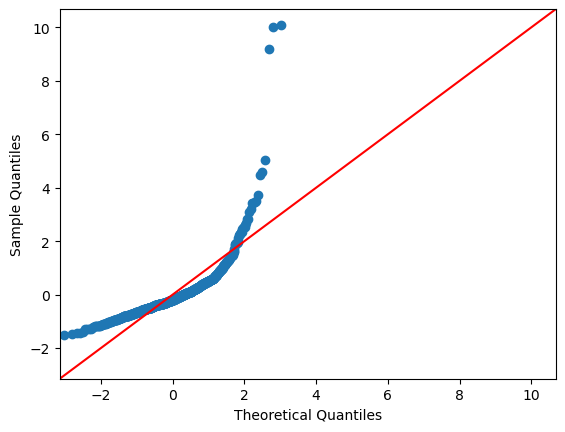

In [ ]:
sm.qqplot(df['duration_seconds'], fit = True, line = '45') 

le tempo semble suivre une loi normale

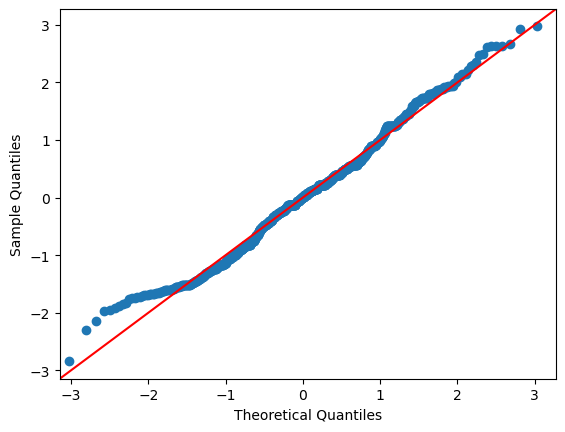

In [ ]:
sm.qqplot(df['tempo'], fit = True, line = '45');

In [ ]:
df.describe()

,danceability,energy,key,loudness,mode,valence,tempo,duration_ms,time_signature,duration_seconds
count,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,8.040000e+02,804.000000,804.000000
mean,0.573817,0.643101,5.263682,-8.026820,0.639303,0.442233,123.842317,2.242509e+05,3.942786,224.247512
std,0.191162,0.217642,3.599865,3.560302,0.480502,0.243053,28.931746,1.092165e+05,0.326054,109.206921
min,0.069300,0.035500,0.000000,-29.477000,0.000000,0.027900,41.629000,5.988900e+04,1.000000,60.000000
25%,0.435750,0.505750,2.000000,-9.624750,0.000000,0.241750,101.060750,1.688365e+05,4.000000,169.000000
50%,0.592000,0.668000,5.000000,-7.380000,1.000000,0.423000,124.015000,2.030340e+05,4.000000,203.000000
75%,0.725000,0.809000,8.000000,-5.670500,1.000000,0.633000,140.023250,2.511360e+05,4.000000,251.250000
max,0.970000,0.997000,11.000000,-0.845000,1.000000,0.971000,210.089000,1.327375e+06,5.000000,1327.000000


In [ ]:
correl,p_value_pearson = sp.pearsonr(df['loudness'],df['danceability'])
print(correl,p_value_pearson)

0.22514869452070385 1.0664418294223998e-10
